# Red Wine Quality Prediction

In [1]:
# Importing packages 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
random.seed(100)
warnings.filterwarnings('ignore')

## Basic data info

In [4]:
# import the data set
with open("winequality-red-4.csv", 'r') as file:
    lines = file.readlines()

# clean column names
headers = lines[0].strip().split(';')
headers = [h.strip('"').strip() for h in headers] # remove colon and space

# clean data rows
# get the data from txt and clean column names, data rows
# the output is a list of lists(row)
data_rows = []
for line in lines[1:]:
    row = line.strip().split(";")
    row = [val.strip('"').strip() for val in row]
    data_rows.append(row)

# creating DataFrame
wine_df = pd.DataFrame(data_rows, columns = headers)

# convert all values to numeric form
wine_df = wine_df.apply(pd.to_numeric, errors = 'coerce')

wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# Range of values for quality
wine_df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

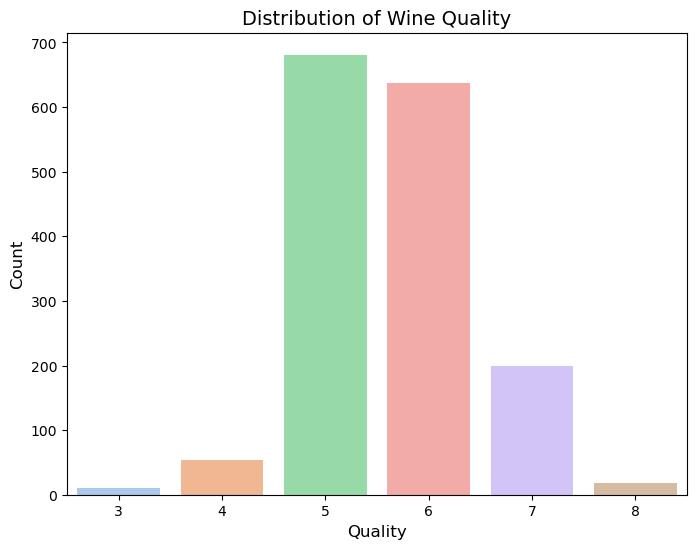

In [8]:
# Distribution in quality
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=wine_df, palette='pastel')
plt.title('Distribution of Wine Quality', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [10]:
# General information of the data
print(wine_df.info())
print(wine_df.describe())

# Check for missing values
wine_df.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

## Data analysis and Visualisation

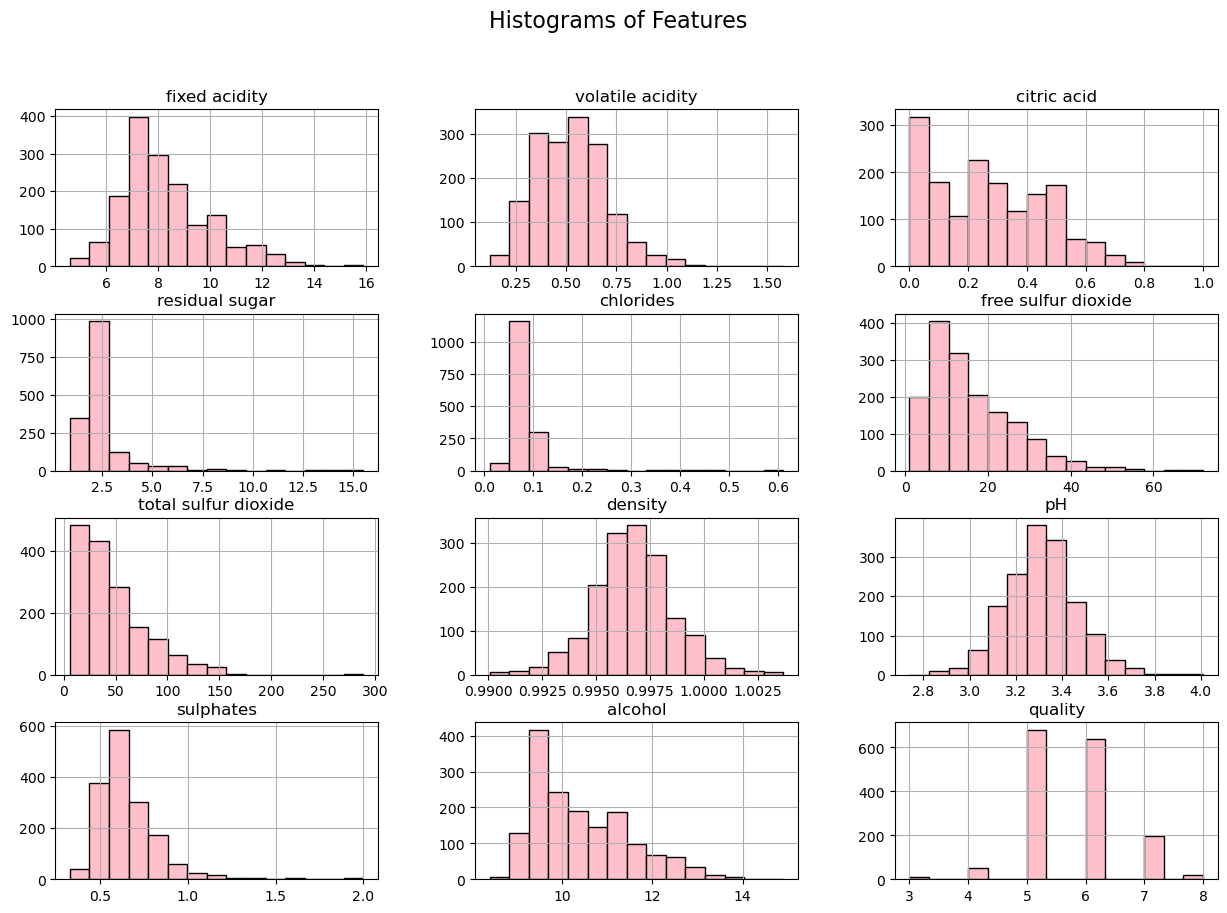

In [13]:
# Histograms of Features
# Visualize the distribution of the quality
# sns.countplot(x='quality', data = df_cleaned)
# plt.title('Distribution of Wine Quality')

# plt.show()
# Feature Distributions (Histograms for Numerical Features)
wine_df.hist(bins=15, figsize=(15, 10), layout=(4, 3), color='pink', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

### According to the graphs, it is clearly to see that all attributes have outliers with extreme value. We need to scale numerical features in order to reduce skewness at the process of building the model. And there is a class imbalance issues revealed from the histograms, which we want to solve by using SMOTE.

In [16]:
# calculate the correlation between features and quality
correlation_matrix = wine_df.corr()
quality_correlation = correlation_matrix['quality'].sort_values(ascending = False)
print(quality_correlation)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [18]:
# correlation matrix
sns.set(style = 'white')

# compute the correlation matrix
corr = wine_df.corr()
corr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907


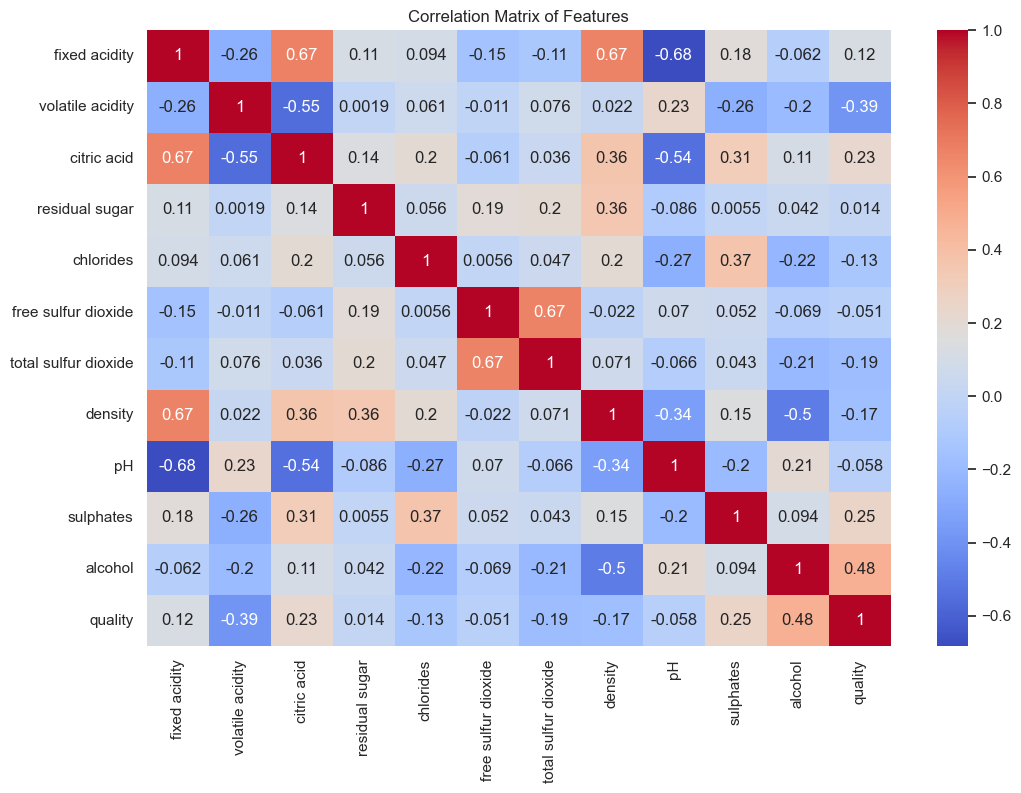

In [20]:
# correlation matrix heat map
plt.figure(figsize = (12, 8))
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

## We plotted the correlation matrix heatmap to analyze the linear correlations between variables and the correlation between variables and quality. We found that the feature most correlated with quality is alcohol, with a correlation coefficient of approximately 0.48. 

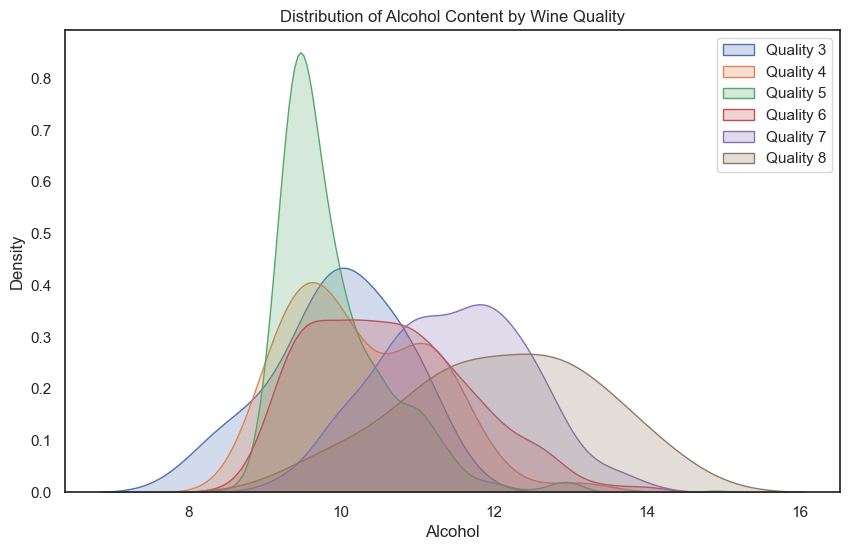

In [23]:
# KDE Plot of Key Features against Target Variable
plt.figure(figsize=(10, 6))
for quality in sorted(wine_df['quality'].unique()):
    subset = wine_df[wine_df['quality'] == quality]
    sns.kdeplot(subset['alcohol'], label=f'Quality {quality}', fill=True)
plt.title('Distribution of Alcohol Content by Wine Quality')
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.legend()
plt.show()

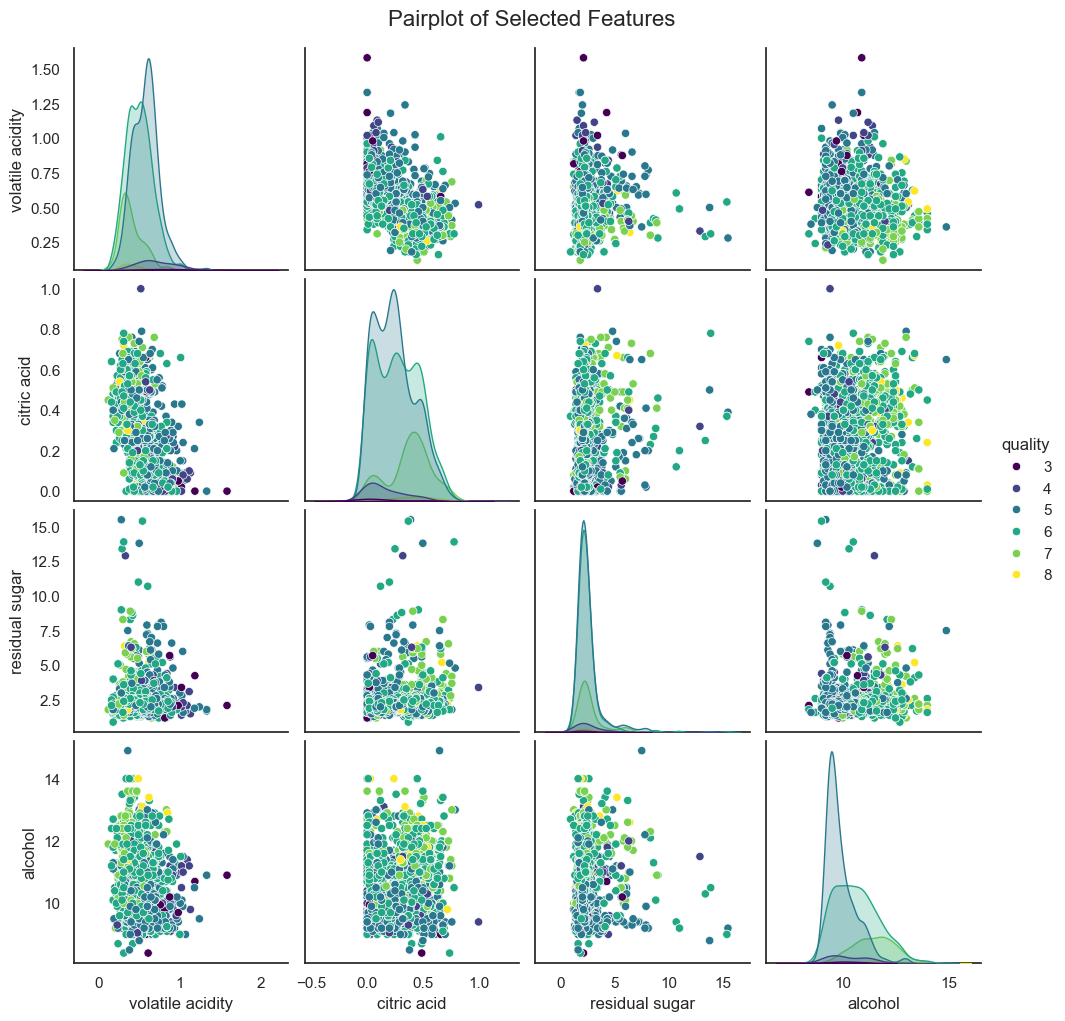

In [25]:
# Pairplot of Selected Features
# should replace citric acid (correlation: 0.23) with solphates (correlation: 0.25)
selected_features = ['volatile acidity', 'citric acid', 'residual sugar', 'alcohol', 'quality']
sns.pairplot(wine_df[selected_features], hue='quality', diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot of Selected Features', y=1.02, fontsize=16)
plt.show()

## Feature selection

In [28]:
# Assign and divide the data set
X = wine_df.drop('quality', axis = 1)
y = wine_df['quality']
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [30]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

In [32]:
wine_df.columns[:11]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [34]:
features_label = wine_df.columns[:11]

In [36]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) fixed acidity                  0.154052
 2) volatile acidity               0.116418
 3) citric acid                    0.107016
 4) residual sugar                 0.099913
 5) chlorides                      0.089030
 6) free sulfur dioxide            0.080517
 7) total sulfur dioxide           0.077752
 8) density                        0.072258
 9) pH                             0.071140
10) sulphates                      0.067320
11) alcohol                        0.064583


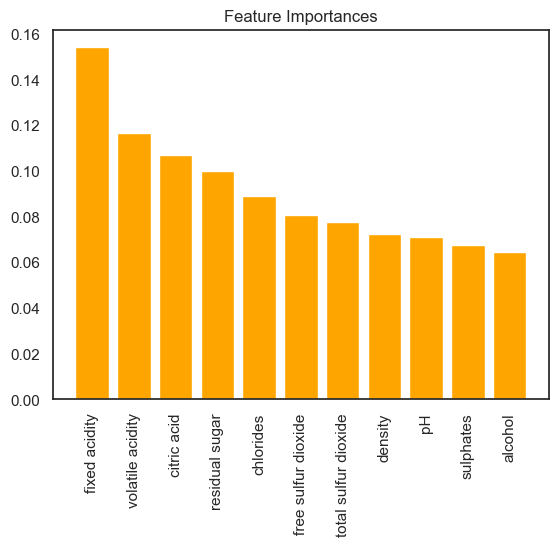

In [38]:
# plot feature importance
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color = "orange", align = "center")
plt.xticks(range(X.shape[1]), features_label, rotation = 90)
plt.show()

In [40]:
## Make binary classification

In [42]:
# make binary classification
from sklearn.preprocessing import LabelEncoder

# classify two different groups for wine in different quality range
wine_df_orig = wine_df['quality']
bins = (2, 5, 10)
group = ['bad', 'good']

# label different range with group label
wine_df['quality'] = pd.cut(wine_df['quality'], bins = bins, labels = group)

# transform text label to numeric form(0/1)
label_quality = LabelEncoder()
wine_df['quality'] = label_quality.fit_transform(wine_df['quality'])

# count
wine_df['quality'].value_counts()

quality
1    855
0    744
Name: count, dtype: int64

<Axes: xlabel='quality', ylabel='count'>

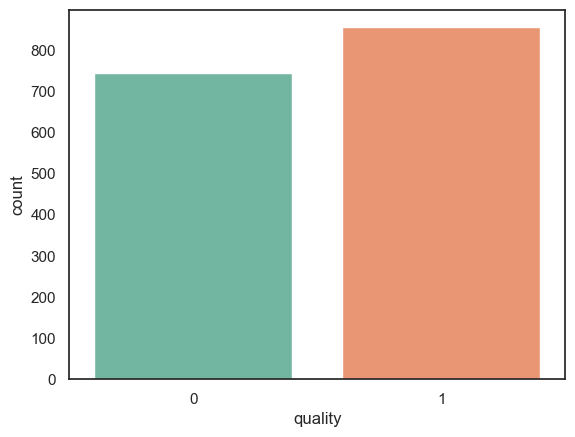

In [44]:
# plot the binary classification data set
sns.countplot(data = wine_df, x = 'quality', palette = 'Set2')

In [46]:
y = wine_df['quality']
y.head()

0    0
1    0
2    0
3    1
4    0
Name: quality, dtype: int32

In [48]:
# Split the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## Feature scaling

In [51]:
# Handle skewed features
#Feature scaling
data_sc = StandardScaler()

# Standardlize the training set and test set
X_train_sc = pd.DataFrame(data_sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(data_sc.transform(X_test))

X_train_sc.columns, X_train_sc.index = X_train.columns, X_train.index
X_test_sc.columns, X_test_sc.index = X_test.columns, X_test.index

X_train = X_train_sc
X_test = X_test_sc


## PCA

In [54]:

# PCA
from sklearn.decomposition import PCA

feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]  
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns

pca = PCA(n_components = 4)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

components_df = pd.DataFrame(pca.components_, columns = feature_names, index = [f'PC{i}' for i in range(4)])
print(components_df)


explained_variance = pca.explained_variance_ratio_
print(pd.DataFrame(explained_variance))


     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
PC0       0.486819         -0.230695     0.467369        0.152336   0.216295   
PC1      -0.109289          0.293355    -0.157400        0.239182   0.149466   
PC2      -0.151640         -0.442608     0.220984        0.049249  -0.021770   
PC3      -0.211996          0.128183    -0.097646       -0.406056   0.663833   

     free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
PC0            -0.035997              0.024603  0.393214 -0.438454   0.245194   
PC1             0.505951              0.562241  0.237128 -0.001219  -0.038717   
PC2             0.441759              0.333724 -0.344715  0.059077   0.338385   
PC3            -0.099858             -0.070716 -0.172567 -0.049175   0.495389   

      alcohol  
PC0 -0.111731  
PC1 -0.409689  
PC2  0.431305  
PC3 -0.175943  
          0
0  0.280177
1  0.175640
2  0.139576
3  0.110818


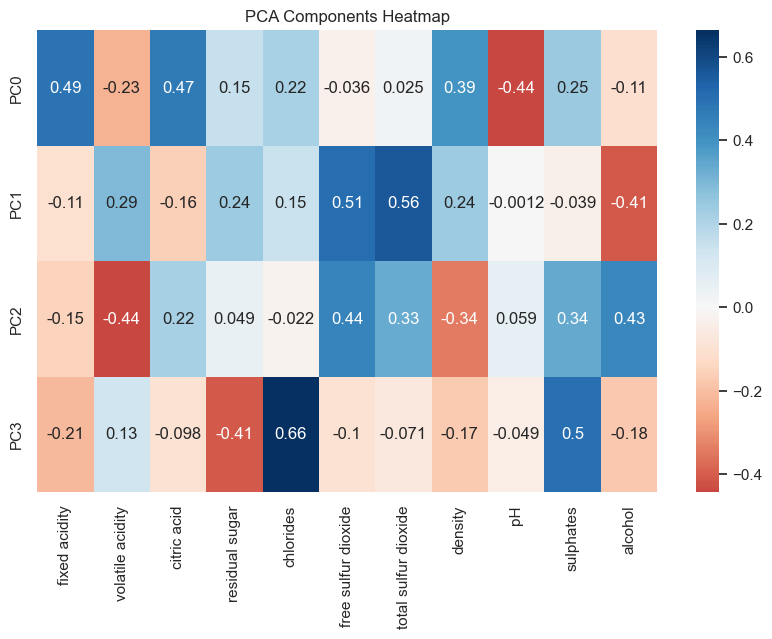

In [56]:
# plot PCA components heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, 
            annot=True, 
            cmap='RdBu', 
            center=0)    
plt.title('PCA Components Heatmap')
plt.show()


## Training and Test

## Dichotomy

In [60]:
# Randomforest
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0, n_estimators = 100, criterion = 'entropy')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = pd.concat([results, model_results], ignore_index=True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (n=100)  0.778125   0.803371  0.798883   0.80112


In [62]:
# SVM （rbf）
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'rbf')
classifier.fit(X_train, y_train)

# predicting test set
y_pred = classifier.predict(X_test)

# metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['SVM(RBF)', acc, prec, rec, f1]],
                columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = pd.concat([results, model_results], ignore_index=True)
print(results)


                   Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (n=100)  0.778125   0.803371  0.798883  0.801120
1               SVM(RBF)  0.712500   0.763636  0.703911  0.732558


In [64]:
# ANN

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (100, 50), 
                        activation = 'relu', 
                        solver = 'adam',
                        max_iter = 1000, 
                        random_state = 42, 
                        learning_rate_init = 0.001,
                        batch_size = 32,
                        early_stopping = True,
                        validation_fraction = 0.1
                        )
mlp.fit(X_train, y_train)

# predicting test set
y_pred = mlp.predict(X_test)

# metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['ANN', acc, prec, rec, f1]],
                columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = pd.concat([results, model_results], ignore_index=True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (n=100)  0.778125   0.803371  0.798883  0.801120
1               SVM(RBF)  0.712500   0.763636  0.703911  0.732558
2                    ANN  0.696875   0.756250  0.675978  0.713864


## Hyperparameter tuning

Fitting 5 folds for each of 16 candidates, totalling 80 fits


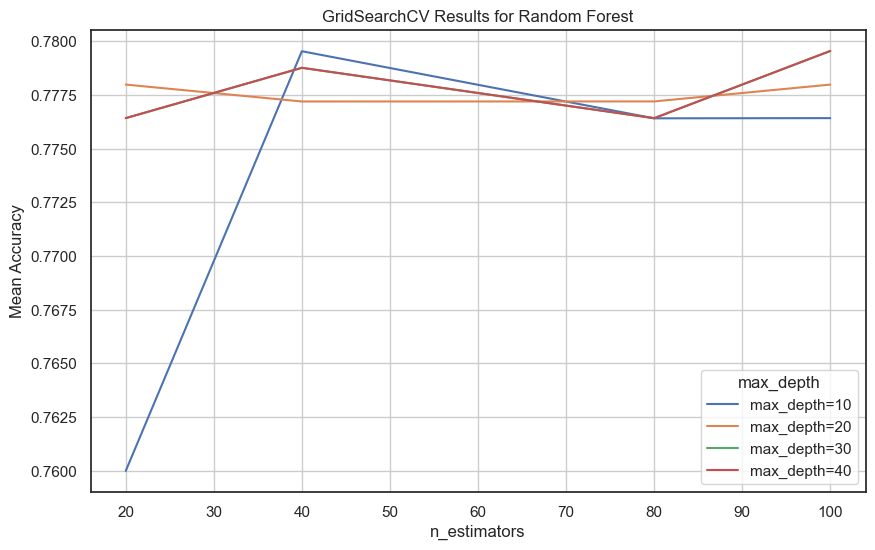

Best Parameters: {'max_depth': 30, 'n_estimators': 100}
Best Score (Accuracy): 0.7795496323529412
Best Model Performance:
Accuracy: 0.7750
Precision: 0.7758
Recall: 0.7750
F1 Score: 0.7753


In [67]:
# Hyperparameter tuning of random forest
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setting parameter grid
param_grid = {
    'n_estimators': [20, 40, 80, 100],
    'max_depth': [10, 20, 30, 40]
}

rf_classifier = RandomForestClassifier(random_state=30)

grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
pivot_table = cv_results.pivot(index='param_n_estimators', 
                               columns='param_max_depth', 
                               values='mean_test_score')
plt.figure(figsize=(10, 6))
for max_depth in param_grid['max_depth']:
    plt.plot(param_grid['n_estimators'], pivot_table[max_depth], label=f"max_depth={max_depth}")

plt.title('GridSearchCV Results for Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('Mean Accuracy')
plt.legend(title='max_depth')
plt.grid()
plt.show()

print("Best Parameters:", grid_search.best_params_)
print("Best Score (Accuracy):", grid_search.best_score_)

best_model = grid_search.best_estimator_  
y_pred = best_model.predict(X_test)       

best_accuracy = accuracy_score(y_test, y_pred)
best_precision = precision_score(y_test, y_pred, average='weighted')
best_recall = recall_score(y_test, y_pred, average='weighted')
best_f1 = f1_score(y_test, y_pred, average='weighted')


print("Best Model Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits


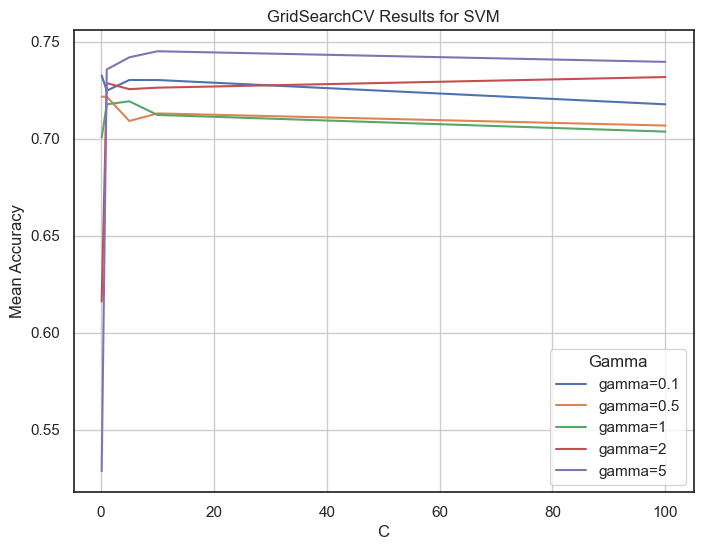

Best Parameters: {'C': 10, 'gamma': 5}
Best Score (Accuracy): 0.745140931372549
Best Model Performance:
Accuracy: 0.7281
Precision: 0.7273
Recall: 0.7281
F1 Score: 0.7275


In [69]:
# Hyperparameter tuning of SVM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.1, 1, 5, 10, 100],
    'gamma': [0.1, 0.5, 1, 2, 5]
}

svm_classifier = SVC(kernel='rbf')

grid_search_svm = GridSearchCV(
    estimator=svm_classifier,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

cv_results_svm = grid_search_svm.cv_results_
C_values = param_grid_svm['C']
gamma_values = param_grid_svm['gamma']
mean_scores = grid_search_svm.cv_results_['mean_test_score']
score_matrix = mean_scores.reshape(len(C_values), len(gamma_values))

plt.figure(figsize=(8, 6))
for i, gamma in enumerate(gamma_values):
    plt.plot(C_values, score_matrix[:, i], label=f"gamma={gamma}")

plt.title('GridSearchCV Results for SVM')
plt.xlabel('C')
plt.ylabel('Mean Accuracy')
plt.legend(title='Gamma')
plt.grid()
plt.show()

print("Best Parameters:", grid_search_svm.best_params_)
print("Best Score (Accuracy):", grid_search_svm.best_score_)

best_model = grid_search_svm.best_estimator_  
y_pred = best_model.predict(X_test)       

best_accuracy = accuracy_score(y_test, y_pred)
best_precision = precision_score(y_test, y_pred, average='weighted')
best_recall = recall_score(y_test, y_pred, average='weighted')
best_f1 = f1_score(y_test, y_pred, average='weighted')


print("Best Model Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


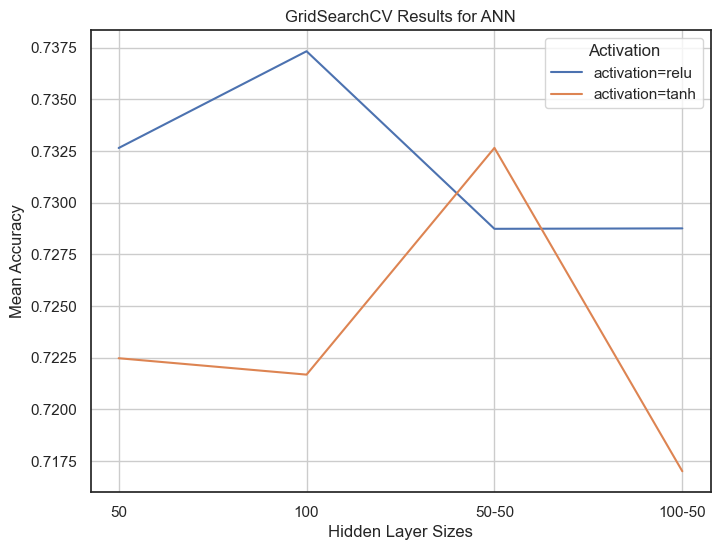

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50)}
Best Score (Accuracy): 0.7373345588235294
Best Model Performance:
Accuracy: 0.6875
Precision: 0.6913
Recall: 0.6875
F1 Score: 0.6885


In [73]:
# Hyperparameter tuning of ANN
param_grid_ann = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh']
}

from sklearn.neural_network import MLPClassifier

ann_classifier = MLPClassifier(max_iter=1000, random_state=30)

grid_search_ann = GridSearchCV(
    estimator=ann_classifier,
    param_grid=param_grid_ann,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search_ann.fit(X_train, y_train)

cv_results_ann = grid_search_ann.cv_results_
hidden_layer_sizes = ['50', '100', '50-50', '100-50']
activations = ['relu', 'tanh']
mean_scores = grid_search_ann.cv_results_['mean_test_score']
score_matrix = mean_scores.reshape(len(hidden_layer_sizes), len(activations))

plt.figure(figsize=(8, 6))
for i, activation in enumerate(activations):
    plt.plot(hidden_layer_sizes, score_matrix[:, i], label=f"activation={activation}")

plt.title('GridSearchCV Results for ANN')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Mean Accuracy')
plt.legend(title='Activation')
plt.grid()
plt.show()

print("Best Parameters:", grid_search_ann.best_params_)
print("Best Score (Accuracy):", grid_search_ann.best_score_)

best_model = grid_search_ann.best_estimator_  
y_pred = best_model.predict(X_test)       

best_accuracy = accuracy_score(y_test, y_pred)
best_precision = precision_score(y_test, y_pred, average='weighted')
best_recall = recall_score(y_test, y_pred, average='weighted')
best_f1 = f1_score(y_test, y_pred, average='weighted')


print("Best Model Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")

## Data supplement

In [4]:

file_path = 'winequality-red-4.csv'
df = pd.read_csv(file_path,
                 sep=';',
                 names=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                       'pH', 'sulphates', 'alcohol', 'quality'],
                 skiprows=1)  # skip first row

# XGBOOST with SMOTE method

Class distribution after SMOTE:
2    681
3    681
4    681
1    681
5    681
0    681
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           3       0.95      1.00      0.97       132
           4       0.88      0.96      0.92       131
           5       0.71      0.75      0.73       150
           6       0.69      0.51      0.59       155
           7       0.82      0.89      0.85       116
           8       0.96      0.99      0.98       134

    accuracy                           0.84       818
   macro avg       0.84      0.85      0.84       818
weighted avg       0.83      0.84      0.83       818


Training Accuracy: 0.9893
Testing Accuracy: 0.8386


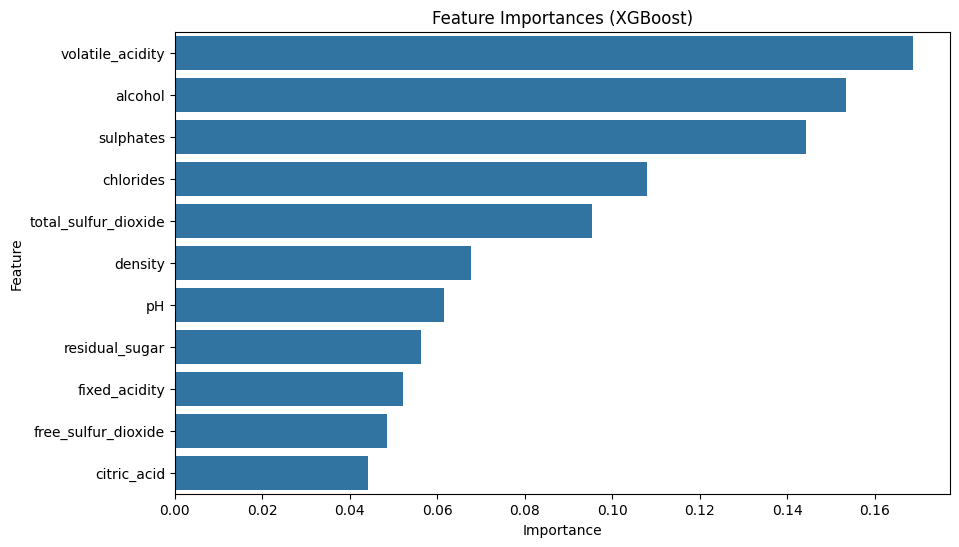

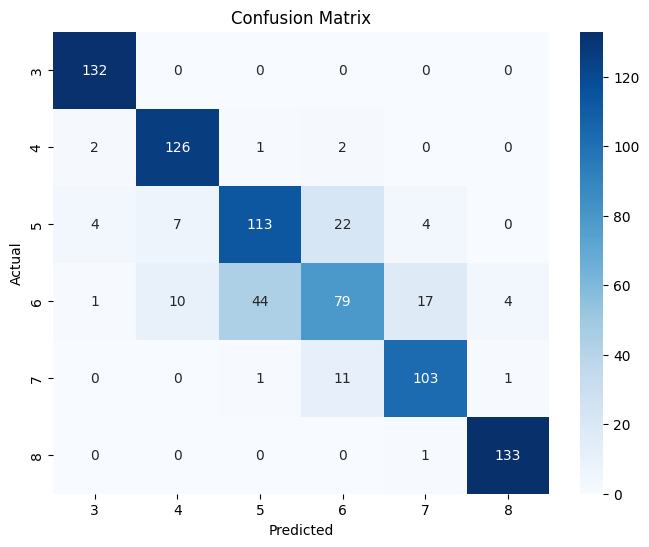


Class Distribution in Original Data:
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already loaded

# 1. Data Preparation
X = df.drop('quality', axis=1)
y = df['quality']  # Directly use quality as the target variable

# Re-map quality classes to be 0-based
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 2. Balance Data Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialize and Train XGBoost Classifier
xgb = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=len(np.unique(y_resampled)), # Number of unique classes
    max_depth=6,               # Tree depth
    learning_rate=0.1,         # Learning rate
    n_estimators=100,          # Number of trees
    random_state=42
)

# Train the model
xgb.fit(X_train_scaled, y_train)

# 6. Predictions
y_pred = xgb.predict(X_test_scaled)

# 7. Evaluation
print("\nClassification Report:")
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))

# Print accuracy
train_accuracy = accuracy_score(y_train, xgb.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# 8. Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances (XGBoost)')
plt.show()

# 9. Confusion Matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 10. Class Distribution in Original Data
print("\nClass Distribution in Original Data:")
print(y.value_counts())


##  Neural Network Model with SMOTE method

Class distribution after SMOTE:
2    681
3    681
4    681
1    681
5    681
0    681
Name: count, dtype: int64
Epoch 1/50
103/103 [==============================] - 0s 1ms/step - loss: 1.4363 - accuracy: 0.4186 - val_loss: 1.1284 - val_accuracy: 0.5648
Epoch 2/50
103/103 [==============================] - 0s 592us/step - loss: 1.1023 - accuracy: 0.5352 - val_loss: 0.9916 - val_accuracy: 0.6210
Epoch 3/50
103/103 [==============================] - 0s 578us/step - loss: 1.0095 - accuracy: 0.5851 - val_loss: 0.9387 - val_accuracy: 0.6479
Epoch 4/50
103/103 [==============================] - 0s 600us/step - loss: 0.9528 - accuracy: 0.6105 - val_loss: 0.8950 - val_accuracy: 0.6516
Epoch 5/50
103/103 [==============================] - 0s 576us/step - loss: 0.8998 - accuracy: 0.6469 - val_loss: 0.8493 - val_accuracy: 0.6944
Epoch 6/50
103/103 [==============================] - 0s 592us/step - loss: 0.8604 - accuracy: 0.6515 - val_loss: 0.8231 - val_accuracy: 0.7066
Epoch 7/50
103/103 [======

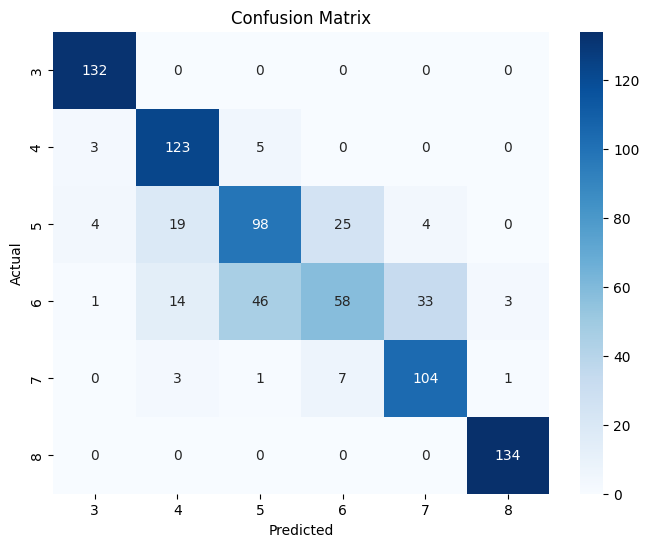

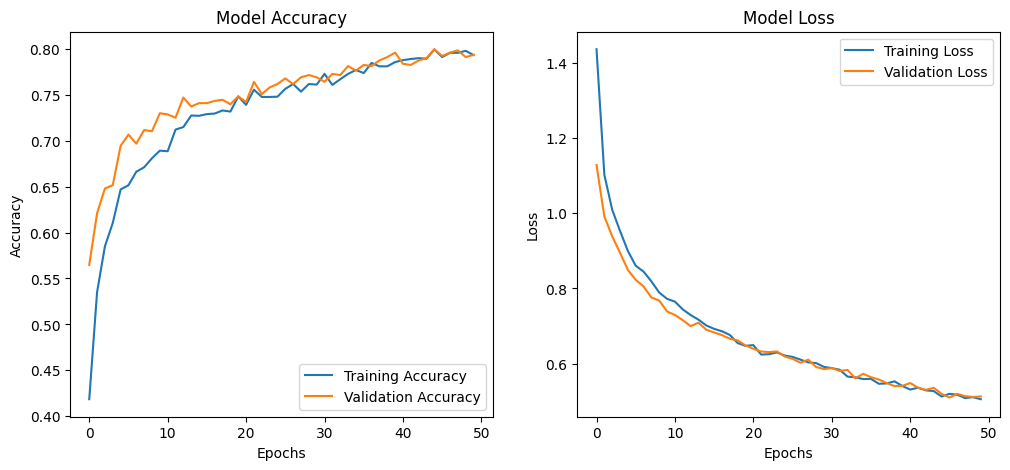


Class Distribution in Original Data:
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Assume df is already loaded

# 1. Data Preparation
X = df.drop('quality', axis=1)
y = df['quality']  # Directly use quality as the target variable

# Re-map quality classes to be 0-based
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

# 2. Balance Data Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
y_resampled_categorical = to_categorical(y_resampled)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_categorical, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Build Neural Network Model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    epochs=50, 
                    batch_size=32,
                    verbose=1)

# 6. Predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 7. Evaluation
print("\nClassification Report:")
print(classification_report(label_encoder.inverse_transform(y_test_classes), label_encoder.inverse_transform(y_pred_classes)))

# Print accuracy
train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# 8. Confusion Matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test_classes), label_encoder.inverse_transform(y_pred_classes))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 9. Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 10. Class Distribution in Original Data
print("\nClass Distribution in Original Data:")
print(y.value_counts())


##  Enhanced Neural Network Model without SMOTE method

Epoch 1/50
123/123 [==============================] - 0s 1ms/step - loss: 1.1593 - accuracy: 0.5179 - val_loss: 1.5981 - val_accuracy: 0.3781
Epoch 2/50
123/123 [==============================] - 0s 739us/step - loss: 1.0086 - accuracy: 0.5798 - val_loss: 1.4187 - val_accuracy: 0.4219
Epoch 3/50
123/123 [==============================] - 0s 718us/step - loss: 0.9443 - accuracy: 0.5563 - val_loss: 1.4169 - val_accuracy: 0.4125
Epoch 4/50
123/123 [==============================] - 0s 722us/step - loss: 0.9252 - accuracy: 0.5680 - val_loss: 1.3586 - val_accuracy: 0.4156
Epoch 5/50
123/123 [==============================] - 0s 715us/step - loss: 0.8493 - accuracy: 0.5513 - val_loss: 1.4658 - val_accuracy: 0.3906
Epoch 6/50
123/123 [==============================] - 0s 733us/step - loss: 0.8997 - accuracy: 0.5693 - val_loss: 1.3952 - val_accuracy: 0.3938
Epoch 7/50
123/123 [==============================] - 0s 738us/step - loss: 0.8335 - accuracy: 0.5607 - val_loss: 1.3392 - val_accuracy: 0

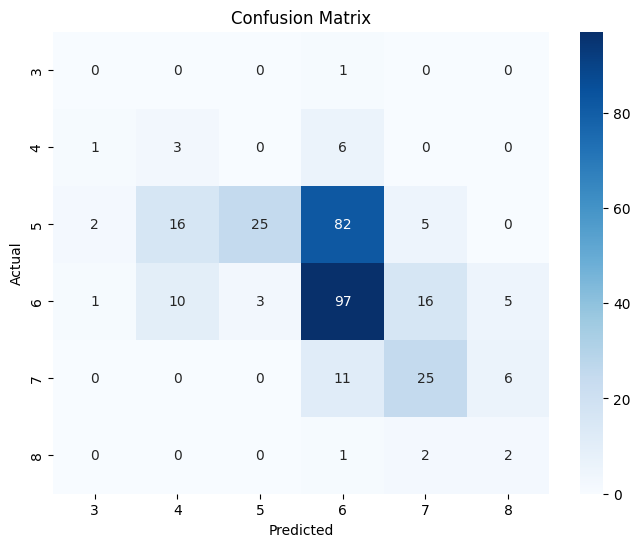

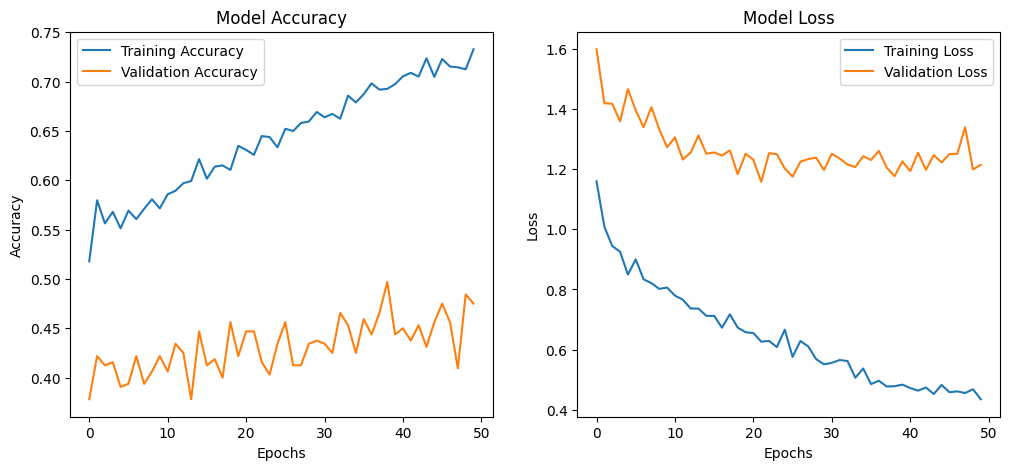


Class Distribution in Original Data:
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [9]:
# Assume df is already loaded

# 1. Data Preparation
X = df.drop('quality', axis=1)
y = df['quality']  # Directly use quality as the target variable

# Re-map quality classes to be 0-based
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

# 2. Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_categorical, axis=1)),
    y=np.argmax(y_categorical, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Data Augmentation for Minority Classes
def augment_minority_classes(X, y):
    augmented_X = []
    augmented_y = []
    for i in range(len(X)):
        if np.argmax(y[i]) in [3, 4, 8]:  # Minority classes
            for _ in range(5):  # Generate 5 augmented samples per sample
                noise = np.random.normal(0, 0.01, X[i].shape)
                augmented_X.append(X[i] + noise)
                augmented_y.append(y[i])
        else:
            augmented_X.append(X[i])
            augmented_y.append(y[i])
    return np.array(augmented_X), np.array(augmented_y)

X_train_augmented, y_train_augmented = augment_minority_classes(X_train_scaled, y_train)

# 6. Build Neural Network Model
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model with custom learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the model with class weights
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

# 7. Predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 8. Evaluation
print("\nClassification Report:")
print(classification_report(label_encoder.inverse_transform(y_test_classes), label_encoder.inverse_transform(y_pred_classes)))

# Print accuracy
train_accuracy = model.evaluate(X_train_augmented, y_train_augmented, verbose=0)[1]
test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# 9. Confusion Matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test_classes), label_encoder.inverse_transform(y_pred_classes))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 10. Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 11. Class Distribution in Original Data
print("\nClass Distribution in Original Data:")
print(y.value_counts())


## Random Forest With SMOTE Method

Class distribution after SMOTE:
2    681
3    681
4    681
1    681
5    681
0    681
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           3       0.95      1.00      0.97       132
           4       0.87      0.96      0.91       131
           5       0.69      0.74      0.71       150
           6       0.70      0.47      0.56       155
           7       0.82      0.91      0.86       116
           8       0.94      0.98      0.96       134

    accuracy                           0.83       818
   macro avg       0.83      0.84      0.83       818
weighted avg       0.82      0.83      0.82       818


Training Accuracy: 0.9780
Testing Accuracy: 0.8289


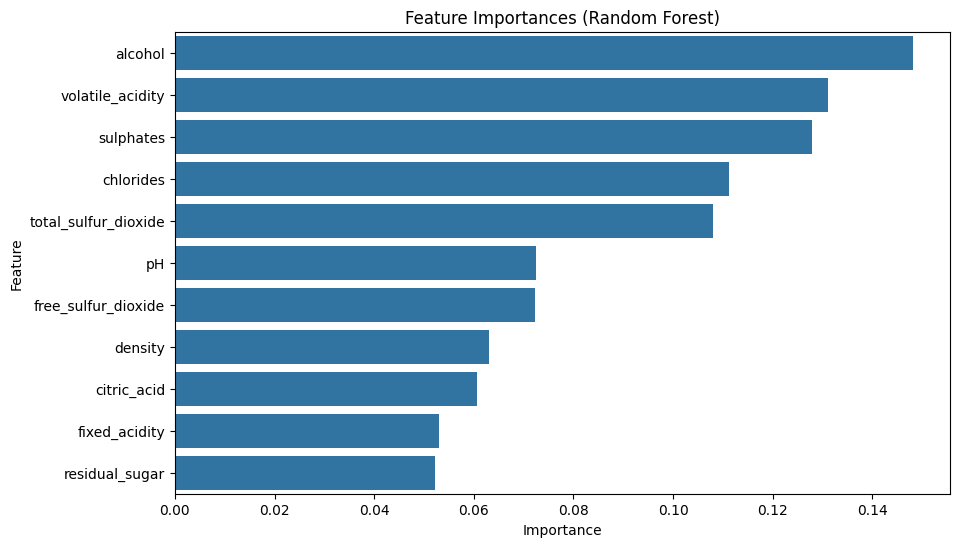

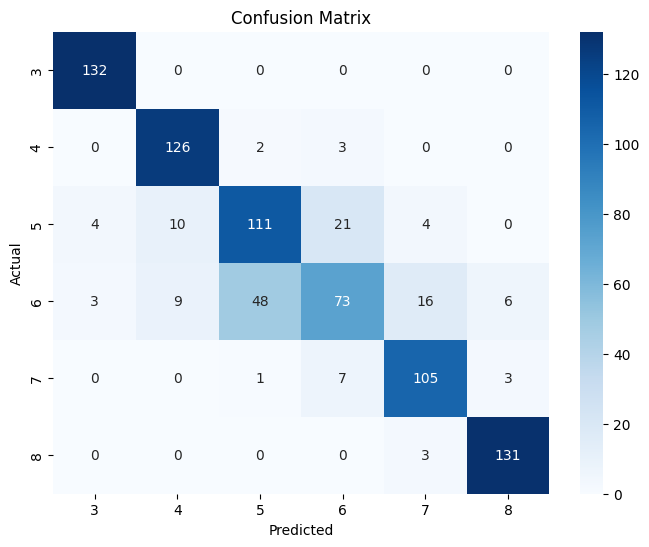


Class Distribution in Original Data:
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
# Assume df is already loaded

# 1. Data Preparation
X = df.drop('quality', axis=1)
y = df['quality']  # Directly use quality as the target variable

# Re-map quality classes to be 0-based
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 2. Balance Data Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=10,              # Tree depth
    random_state=42,           # For reproducibility
    class_weight='balanced'    # Handle class imbalance
)
rf.fit(X_train_scaled, y_train)

# 6. Predictions
y_pred = rf.predict(X_test_scaled)

# 7. Evaluation
print("\nClassification Report:")
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))

# Print accuracy
train_accuracy = accuracy_score(y_train, rf.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# 8. Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()

# 9. Confusion Matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 10. Class Distribution in Original Data
print("\nClass Distribution in Original Data:")
print(y.value_counts())
